# Contagion in Collateral and Debt Markets Numerical Analysis
To highlight key attributes of the model, we conduct various numerical tests. First, we evaluate the number of defaulting agents for various network structures under different shock regimes when the collateral channel is excluded, confirming the main results from Acemoglu, Ozdaglar, and Tahbaz-Salehi (2015). When agents hold assets and post portions of them as collateral, we extend the results by including a third dimension for collateral ratio. Lastly, we examine the $\delta$-connected network by defining $\delta$ to be each agent's individual debt exposure to each agent within an opposing component in the network. We then compare levels of default and the equilibrium price of assets across changes in $\delta$ as a percentage and collateral ratio. (Original paper found here: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3983535) Last updated: 12/19/2022

In [4]:
using LinearAlgebra
using SymPy
using Pkg
using Plots; gr() # set a different backend
using Distributions
using DataFrames
using CSV

## Networks and Helper Functions
Creates the complete, ring, gamma-convex, and delta-connected networks

In [41]:
# Create different networks in matrix form
function complete_network(Dweight,n)
    # eye matrix
    eye = Diagonal(ones(n,n))-zeros(n,n); 
    
    # base debt weight matrix
    D = ones(n,n)-eye; 

    # complete network 
    Dc = D.*Dweight/(n-1);
    return Dc
end

function ring_network(Dweight,n)
    # eye matrix
    eye = Diagonal(ones(n,n))-zeros(n,n);
    
    # ring network 
    lc = eye[[n],:];
    mc = eye[1:n-1,:];
    Dr = Dweight*vcat(lc,mc);
    return Dr
end

function gamma_network(Dweight,n,gamma)
    Dc = complete_network(Dweight,n)
    Dr = ring_network(Dweight,n)
    # gamma-convex of ring and complete
    Dg = (gamma*Dc)+((1-gamma)*Dr);
end

# delta network is assumed to be 2 complete network components
function delta_network(Dweight,n,delta)
    r = Int(n/2);
    weight = delta*Dweight
    main_weight = Dweight-weight*r
    Dp = complete_network(main_weight,r)
    Z = weight*ones(r,r);
    Dd = [Dp Z ; Z Dp]
    return Dd
end

function gamma_delta_network(Dweight,n,delta,gamma)
    r = Int(n/2);
    weight = delta*Dweight
    main_weight = Dweight-weight*r
    Dp = gamma_network(main_weight,r,gamma)
    Z = weight*ones(r,r);
    Dd = [Dp Z ; Z Dp]
    return Dd
end

# helper function for making weights according to the weighting rule
function weights(D,C,p)
    # first create an nxn matrix of excess collateral values
    EC = D-C.*D.*p;
    
    # replace values with 0 if value is negative
    EC[EC.<0].=0;
    
    # create total collateral per agent matrix values for denominator
    den = sum(EC,dims=1);
    #den[den.<0].=0;
    
    # create weights
    Q = EC./den;
    
    # replace undefined values with 1
    Q[(isnan.(Q)).|(Q.==Inf).|(Q.==-Inf)] .= 1;
    
    return Q
end

# solves for equilibrium x payment values
function x_solve(d_hat,z_hat,Q,xi,p,s,zeta)
    x_hat = d_hat;
    check=true;
    while check
        #calculate l_hat
        if p >=s*zeta
            l_hat = max.(zeros(n,1),min.(1/zeta*(d_hat-Q*x_hat-z_hat),xi.*ones(n,1)));
        else
            l_hat = xi.*ones(n,1);
        end
        x_hat2 = max.(zeros(n,1),min.(Q*x_hat+z_hat+zeta*l_hat,d_hat)); # calculate x_hat directly, which is the sum of all agents' payments
        #check if x_hat = x_hat2 with some margin, if not then we continue
        #loop and reassign x_hat to the minimum statement
        test = sum((x_hat-x_hat2).^2);
        if test <= 1e-10
            check = false;
        end
        x_hat = x_hat2;
    end
    return x_hat
end

# calculates c understar
function c_understar(Dweight,n,ei,s,h0_w,k)
    cs = (Dweight-((n-k)/k)*ei)/(Dweight*s)+h0_w/Dweight;
    return cs
end

# calculates c upperstar
function c_upperstar(s,n,k,ei,h0_w)
    c_star = (min(s,(n-k)*ei/(k*h0_w)))^-1;
    return c_star
end

c_upperstar (generic function with 1 method)

## Equilibrium Function

Definition 1: For given $ (N,C,D,e,h, s, \omega) $, if liquidation decisions $ \{l_j(p)\} $ satisfy the liquidation rule, payments $ \{x_{ij}(p)\}  $ satisfy the payment rule, $ \{m_j(p)\} $ is determined by net wealth equation, fire sale amount $\{\phi_j(p)\}$ determined by the fire-sale equation, and price  $ p $ clears the market according to the market clearing condition then $  (\{x_{ij}\},\{l_j\},\{m_j\}, \{\phi_j\},p) $ is a full equilibrium.

This function identifies the full equilibrium as defined in definition 1 and returns $p$ and the number of defaults. Agent $j$ defaults when $m_j \leq 0$.

In [7]:
function equ(s,n,e0,epsilon,xi,zeta,C,D,omega,h0)
    
    # check for while loop to end when equilibrium is found
    look = true;

    # start with p equalling fair value s 
    p=s;
  
    # assign increment for when loop decreases p 
    inc = 0.01; 
    
    while look
        
        # Collateral matrix in monetary terms (n x n)
        cdp = C.*D.*p;
        
        # Collateral matrix in non-monetary terms (n x n)
        cd = C.*D;

        # Debt-Collateral matrix (owed net amount) (n x n)
        d_cdp = D-cdp;

        # Weighting matrix, pro-rata (n x n)
        Q = weights(D,C,p); 
  
        # total debt owed per agent w/ collateral netting (n x 1)
        d_cdp[d_cdp.<0].=0;
        d_hat = d_cdp;
        d_hat = transpose(sum(d_hat,dims=1));

        # collateral matrix in monetary terms (n x n)
        cp = C*p;

        # establish indicator matrix denoting which collateral are greater than 1 or less than 1 (n x n)
        b1 = cp.>1; 
        b2 = cp.<=1; 

        # construct cash, asset and z_hat vectors (n x 1)
        e_hat = e0 + (D.*b1)*ones(n,1) - (transpose(D.*b1))*ones(n,1); 
        h_hat = h0 + (cd.*b2)*ones(n,1) - (transpose(cd.*b2))*ones(n,1);
        z_hat = e_hat + h_hat*p - omega*epsilon;
        
        # solve for x payments 
        x = x_solve(d_hat,z_hat,Q,xi,p,s,zeta)
        
        # plug in x to solve for l_hat in numeric terms
        if p >=s*zeta
            A = 1/zeta*(d_hat-Q*x-z_hat);
            B = xi.*ones(n,1);
            term = min.(A,B);
            l_hat = max.(term,zeros(n,1)); # maximum term
        else
            l_hat = xi.*ones(n,1);
        end

        # use threshold (tol = 1.1102e-16) to ensure cases like boolean 18.6 == 18.600000 are
        # recognized to equal 1 and not 0
        tol = eps(0.5);
        d_solvent = (abs.(x-d_hat).<tol);
        d_default = ones(n,1) - d_solvent;

        # full payment matrix of all agents, sum of defaulting and solvent agents' payments (n x n)
        all_X = d_cdp.*(transpose(d_solvent))+ Q.*(transpose(x).*transpose(d_default));
        
        # agents' wealth (n x 1)
        w = e_hat + h_hat*p - omega*epsilon + zeta*l_hat + all_X*ones(n,1) - x;
        
        # sum of non-defaulting agents' assets (s)
        nd_assets = 0;

        # of defaulting agents
        def = 0;

        # second term for the numerator in price equation
        num = 0;
        
        # count the number of defaults
        for i= 1:n
            if w[i,1] > 1e-10
                nd_assets = nd_assets+h0[i,1];
                num = num+max(0,h0[i,1]*p-w[i,1]);
            else
                def = def+1;
            end
        end
        
        # fire sales
        temp = min.(max.(h0*p-w,zeros(n,1)),h0*p);
        phi = sum(temp);

        # check if there's enough cash in the market to buy fire sales, if
        # so then price will be fair value; else calculate liquidity
        # constrained price
       
        condition = sum(max.(zeros(n,1),w.-h0*s));
        if p == s && condition>=phi
            p_new = s; 
        else
            if nd_assets == 0
                p_new = 0; # everyone defaulting meaning the asset is worthless 
            else
                total_wealth = sum(max.(zeros(n,1),w))
                p_new = total_wealth/sum(h0); # liquidity constrained price
            end
        end
        # total value of liquidations
        l = length(l_hat[l_hat.>0]); 
        
        # calculate difference between inputted p and re-calculated p
        d=abs(p-p_new);
        
        # check if market clearing p is the guessed p 
        if d <= 0.01||p_new > p 
            p = p_new;
         
            # total value of liquidations
            l = length(l_hat[l_hat.>0]); 

            # stop looking and return p
            look = false; 
            
            # return defaults and price
            return def,p
            
        else
            # try a different p value
            p = p-inc;  
        end
        
        # market crash if price is 0
        if p < 0.0001
            p = 0;
            return def,p
        end
    end
end

equ (generic function with 1 method)

# Graphing Functions

In [34]:
# graph changing epsilons
function graph_e(n,e0,h0,s,xi,zeta,omega,C,ei,Dc,Dr,Dd=false,Dg=false,prices = false)
    
    # calculate upperbound, a little larger than epsilon star
    ub = 1.2*ei*n;

    # set range: iterate in increments of 0.1 from 0.9 to upperbound
    range = 0:0.1:ub;
    num_x = length(range);
    y1 = zeros(num_x,1);
    y2 = zeros(num_x,1);
    y3 = zeros(num_x,1);
    y4 = zeros(num_x,1);

    y11 = zeros(num_x,1);
    y22 = zeros(num_x,1);
    y33 = zeros(num_x,1);
    y44 = zeros(num_x,1);

    iub = length(range);
    for i = 1:iub
        m = range[i];
        epsilon = ei*m;

        # calculate utilities and liquidations
        defc, pc = equ(s,n,e0,epsilon,xi,zeta,C,Dc,omega,h0);
        y1[i] = defc;
        y11[i] = pc;

        defr, pr = equ(s,n,e0,epsilon,xi,zeta,C,Dr,omega,h0);
        y2[i] = defr;
        y22[i] = pr;
        
        if Dd != false
            defd, pd = equ(s,n,e0,epsilon,xi,zeta,C,Dd,omega,h0);
            y3[i] = defd;
            y33[i] = pd;
        end
        
        if Dg != false
            defg, pg = equ(s,n,e0,epsilon,xi,zeta,C,Dg,omega,h0);
            y4[i] = defg;
            y44[i] = pg;
        end

    end
    if prices
        return range,y11,y22,y33,y44
    else
        return range,y1,y2,y3,y4
    end
end 

# graph changing epsilons and collateral
function graph_3d(n,e0,h0,h0_w,s,xi,zeta,omega,ei,D,Dweight)
    
    # calculate upperbound, a little larger than epsilon star
    ub = 1.5*ei*n;

    # set range: iterate in increments of 0.1 from 0.9 to upperbound
    range = 0:0.1:ub;
    num_x = length(range);
    #cstar = c_understar(Dweight,n,ei,s,h0_w);
    cstar = c_upperstar(s,n,1,ei,h0_w);
    c_ub = round(h0_w*n/Dweight,digits=2)
    c_range = Array(0.01:0.01:c_ub);
    total_obs = num_x*length(c_range);
    epsilons = zeros(total_obs,1);
    collateral_ratios = zeros(total_obs,1);
    defaults = zeros(total_obs,1);
    prices = zeros(total_obs,1);
    ind = 1
    
    for i = 1:num_x
        m = range[i];
        epsilon = ei*m;
        
        for j in 1:length(c_range)
        
            c = c_range[j];
            
            C = ones(n,n)*c
            
            # add epsilon and c to arrays
            epsilons[ind] = epsilon
            collateral_ratios[ind] = c
            
            # calculate utilities and liquidations
            def, p = equ(s,n,e0,epsilon,xi,zeta,C,D,omega,h0);
            defaults[ind] = def;
            prices[ind] = p;
            
            # add to indicator
            ind+=1
        end

    end
    return Array(epsilons), Array(collateral_ratios),Array(defaults),Array(prices)
end

graph_3d (generic function with 1 method)

## Network Contagion Patterns without Collateral Channel
Our model extends Acemoglu, Ozdaglar, and Tahbaz-Salehi (2015) where agents can commit a portion of held assets $(h_0)$ as collateral. Therefore, our models' results should replicate Acemoglu, Ozdaglar, and Tahbaz-Salehi (2015) when the asset value $(h_0)$ and collateral ratio $(c)$ are 0 for all agents. To test this, we run a numerical simulation that compares the stability and resilience of the complete network, ring network, $ \delta $-connected network when $\delta=0$, and a $\gamma$-convex combination of the complete and ring networks when $\gamma=0.5$ by measuring the number of defaults across varying liquidity shocks $(\epsilon)$. The $\delta$- network is structured as two discrete components of complete networks, each containing half of the agents. We assume homogeneity where all agents have the same debt $(d)$ obligations and cash endowments$(e_0)$ to ensure that the variation in our results are solely attributed to the variation in network structures. In this setup of 20 agents with no assets and collateral, $e_0$ is 1 and $d$ is $2d^*$. Only one agent is hit with the liquidity shock at a given time.

## Parameter Setup

In [69]:
n = 20 # 20 agents
s = 1 # fair value of 1
ei = 1 # cash unit of 1
e0 = ei*ones(n,1) # vector of cash values
epsilon_star = ei*n # epsilon star value
xi = 10 # long term project return
zeta = 1e-10 # liquidation inefficiency
dstar = (n-1)*ei

# total agent liability
Dweight = 2*dstar

# construct networks
Dc = complete_network(Dweight,n)
Dr = ring_network(Dweight,n)
Dg = gamma_network(Dweight,n,0.5)
Dd = delta_network(Dweight,n,0) # delta=0 network

# hit only one agent with liqudity shock
omega = zeros(n,1);
omega[1,1] = 1;
k = 1;

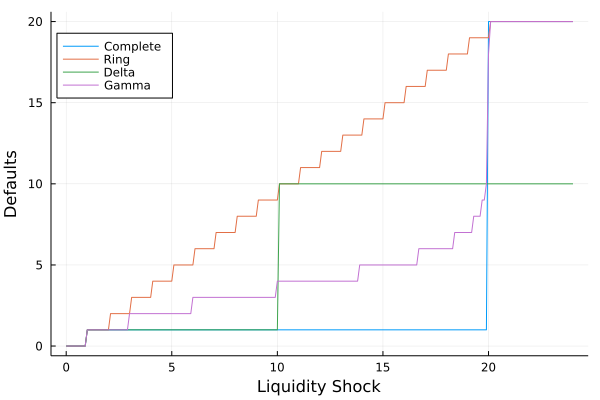

In [36]:
C = zeros(n,n) # collateral-debt ratio matrix of 0 (n x 1)
h0 = zeros(n,1) # no assets

range,y1,y2,y3,y4 = graph_e(n,e0,h0,s,xi,zeta,omega,C,ei,Dc,Dr,Dd,Dg)
Plots.plot(range, y1, label="Complete")
Plots.plot!(range, y2,label = "Ring")
Plots.plot!(range, y3, label="Delta")
Plots.plot!(range, y4, label="Gamma", legend=(0.1, 0.9), ylabel= "Defaults", xlabel="Liquidity Shock")
#savefig("numerical_simulations/unsecured_debt_case.png")

## Network Contagion Patterns with Collateral Channel
Now, we evaluate how stability, resiliency, and collateral price changes when agents can commit asset endowments as collateral. Using the same setup in the previous section, but $c > 0$ and $h_0 = 2$, we model each network's number of defaults under varying shocks ($\epsilon$) and collateral ratios ($c$). The collateral ratio ranges from 0 to $c^*$, $c^*$ being 1 and $c_*$ being 0.55 and the collateral's fair value ($s$) is 1.

In [37]:
# make sure asset exists with collateral model!
h0_w = 2;
h0 = h0_w*ones(n,1);

In [43]:
cstar = c_understar(Dweight,n,ei,s,h0_w,1)
println("c understar:",cstar)

c understar:0.5526315789473684


In [38]:
# run simulations and produce results
epsilons_r, collateral_ratios_r,liquidations_r, prices_r=graph_3d(n,e0,h0,h0_w,s,xi,zeta,omega,ei,Dr,Dweight);
epsilons_c, collateral_ratios_c,liquidations_c, prices_c=graph_3d(n,e0,h0,h0_w,s,xi,zeta,omega,ei,Dc,Dweight);
epsilons_g, collateral_ratios_g,liquidations_g, prices_g=graph_3d(n,e0,h0,h0_w,s,xi,zeta,omega,ei,Dg,Dweight);
epsilons_d, collateral_ratios_d,liquidations_d,prices_d=graph_3d(n,e0,h0,h0_w,s,xi,zeta,omega,ei,Dd,Dweight);

In [13]:
# if we wanted to write results into csv
#mytable = DataFrame(Dict("epsilons"=>vec(epsilons_r),"c"=>vec(collateral_ratios_r),"l"=>vec(liquidations_r)))
#CSV.write("simulation_results.csv",mytable)

## Plotting Defaults

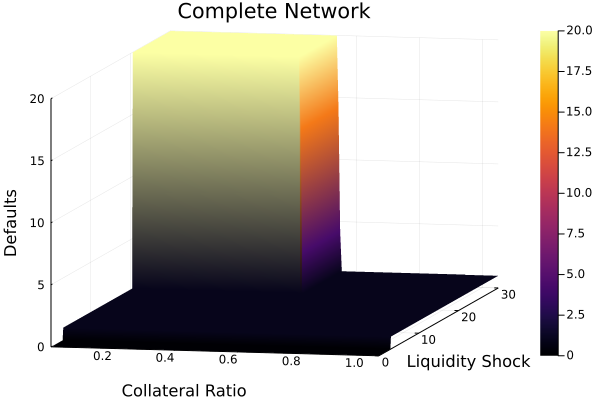

In [39]:
Plots.surface(vec(collateral_ratios_c),vec(epsilons_c),vec(liquidations_c),title="Complete Network",camera=(20,30),xlabel="Collateral Ratio",ylabel="Liquidity Shock",zlabel="Defaults")
#savefig("numerical_simulations/3d_complete_temp.png")

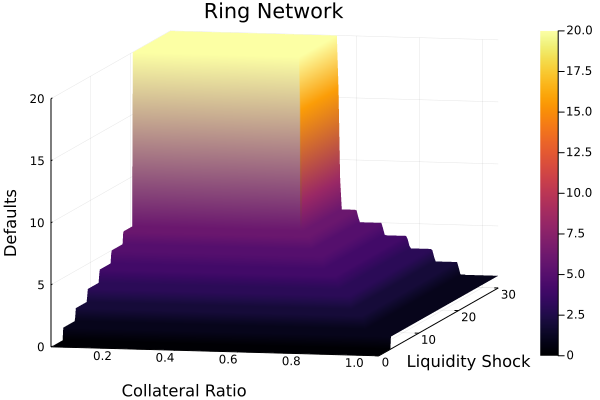

In [44]:
Plots.surface(vec(collateral_ratios_r),vec(epsilons_r),vec(liquidations_r),title="Ring Network",camera=(20,30),xlabel="Collateral Ratio",ylabel="Liquidity Shock",zlabel="Defaults")
#savefig("numerical_simulations/3d_ring_temp.png")

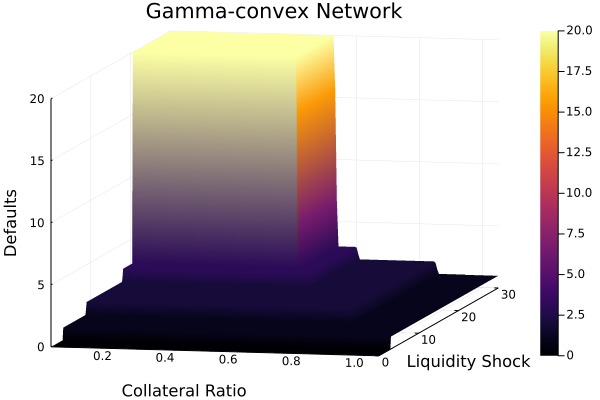

In [45]:
Plots.surface(vec(collateral_ratios_g),vec(epsilons_g),vec(liquidations_g),title="Gamma-convex Network",camera=(20,30),xlabel="Collateral Ratio",ylabel="Liquidity Shock",zlabel="Defaults")
#savefig("numerical_simulations/3d_gamma_temp.png")

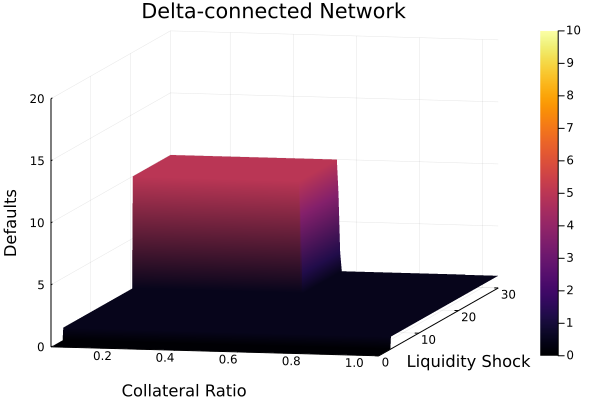

In [46]:
Plots.surface(vec(collateral_ratios_d),vec(epsilons_d),vec(liquidations_d),title="Delta-connected Network",camera=(20,30),zlim=(0,20),xlabel="Collateral Ratio",ylabel="Liquidity Shock",zlabel="Defaults")
#savefig("numerical_simulations/3d_delta_temp.png")

## Plotting Prices

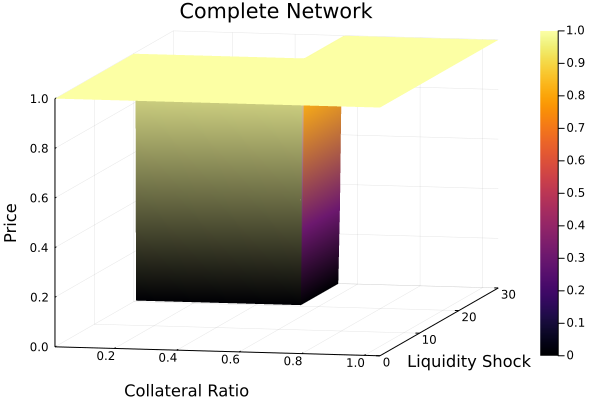

In [47]:
Plots.surface(vec(collateral_ratios_c),vec(epsilons_c),vec(prices_c),title="Complete Network",camera=(20,30),xlabel="Collateral Ratio",ylabel="Liquidity Shock",zlabel="Price")
#savefig("numerical_simulations/3d_complete_p.png")

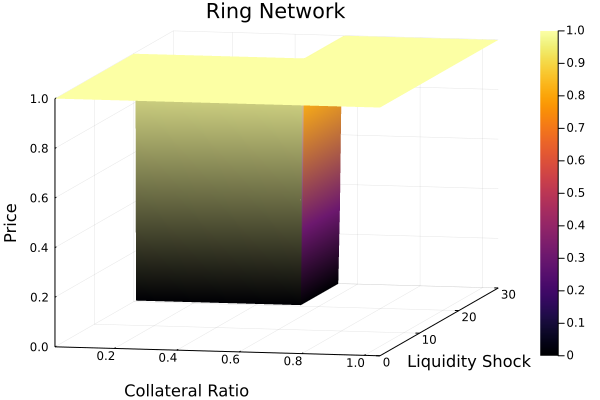

In [48]:
Plots.surface(vec(collateral_ratios_r),vec(epsilons_r),vec(prices_r),title="Ring Network",camera=(20,30),xlabel="Collateral Ratio",ylabel="Liquidity Shock",zlabel="Price")
#savefig("numerical_simulations/3d_ring_p.png")

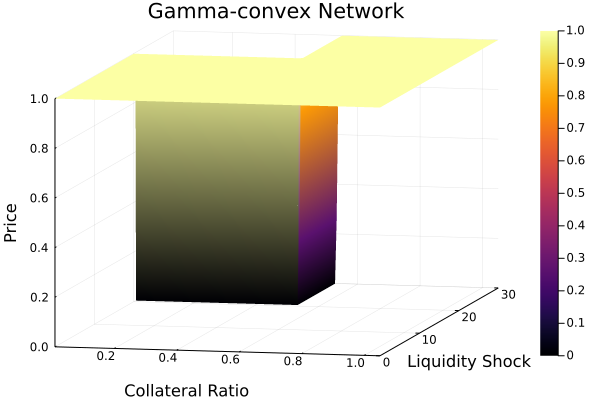

In [49]:
Plots.surface(vec(collateral_ratios_g),vec(epsilons_g),vec(prices_g),title="Gamma-convex Network",camera=(20,30),xlabel="Collateral Ratio",ylabel="Liquidity Shock",zlabel="Price")
#savefig("numerical_simulations/3d_gamma_p.png")

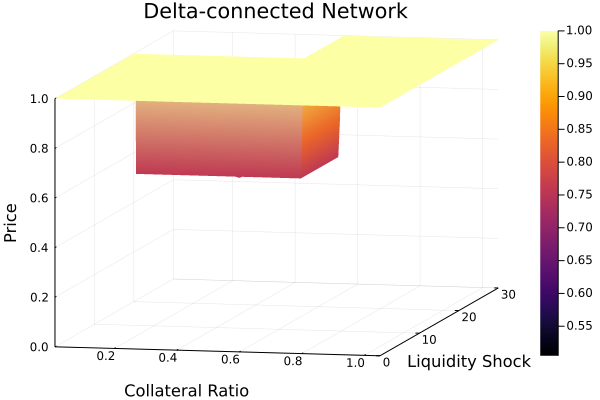

In [50]:
Plots.surface(vec(collateral_ratios_d),vec(epsilons_d),vec(prices_d),title="Delta-connected Network",camera=(20,30),zlim = (0,1), xlabel="Collateral Ratio",ylabel="Liquidity Shock",zlabel="Price")
#savefig("numerical_simulations/3d_delta_p.png")

# Delta-connected Network
In this experiment, we evaluate networks of 20 agents where each agent has 1 unit of cash, 2 assets, and a total liability of $d=2d^*=38$. One agent out of the 20 receives a large liquidity shock of $\epsilon > \epsilon^*=20$. The network is segmented into two even components $S$ and $S^c$ where each agent owes a large liability of $(d-10\delta d)/{9}$ to every agent within her own component and a small liability of $\delta d$ to every agent in the opposing component. Let $\delta^*$ be defined as the minimum $\delta$ value such that the $\delta$-connected network is the least stable network. We evaluate changes in $\delta$ represented as a percentage called intercomponent exposure against changes in the collateral ratio and measure the network's number of defaults and the equilibrium asset price.

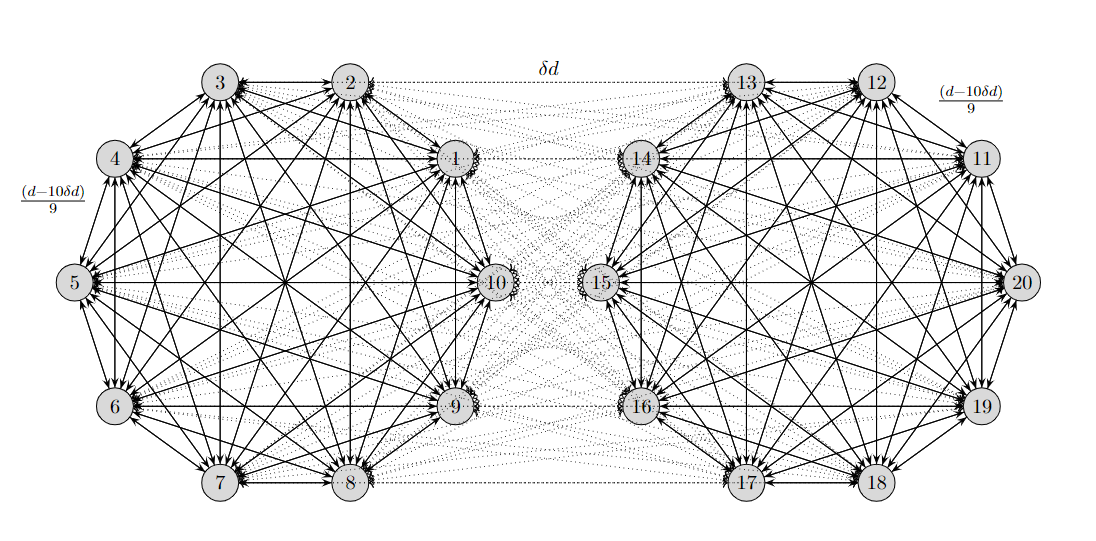

In [75]:
# for a given delta-connected network of 2 gamma-convex (of complete and ring networks) components, find delta star (network default threshold)
# note: when gamma = 1, the components are simply complete, when gamma =0, components are ring
function find_delta_star(n,Dweight,s,e0,epsilon_star,xi,zeta,omega,h0,gamma)
    C = ones(n,n)*0.02
    epsilon = 2*epsilon_star
    delta_ub = 1/(n-1)
    delta_range = 0:0.0001:delta_ub
    len_dr = length(delta_range)
    for ind in 1:len_dr
        delta = delta_range[ind]
        #Dld = delta_network(Dweight,n,delta,ring) 
        Dld = gamma_delta_network(Dweight,n,delta,gamma)
        default = equ(s,n,e0,epsilon,xi,zeta,C,Dld,omega,h0)
        if default[1] == n
            return delta, default
        end
    end
    return "no delta star"
end

function graph_agg_delta(n,Dweight,s,e0,ei,epsilon_star,xi,zeta,omega,h0,k,gamma)
    epsilon = 2*epsilon_star
    c_bound = c_understar(Dweight,n,ei,s,h0_w,k)
    collateral_range = 0:0.01:(c_bound+0.15)
    #delta_ub = 1/(n-1)
    delta_ub = 0.0100
    delta_range = 0:0.0001:delta_ub
    len_dr = length(delta_range)
    def_list = []
    price_list = []
    delta_values = []
    collateral_values = []
    for c in collateral_range
        C = ones(n,n)*c
        for ind in 1:len_dr
            delta = delta_range[ind] #in percentage
            Dld = gamma_delta_network(Dweight,n,delta,gamma)
            default = equ(s,n,e0,epsilon,xi,zeta,C,Dld,omega,h0)
            push!(def_list,default[1])
            push!(price_list,default[2])
            push!(delta_values,delta*100)
            push!(collateral_values,c)
        end
    end
    return delta_values,def_list,price_list,collateral_values
end

graph_agg_delta (generic function with 2 methods)

In [57]:
delta_star = find_delta_star(n,Dweight,s,e0,epsilon_star,xi,zeta,omega,h0,1)
println("delta^* = ",delta_star[1])

delta^* = 0.0048


In [64]:
delta_values,def_list,price_list,collateral_range=graph_agg_delta(n,Dweight,s,e0,ei,epsilon_star,xi,zeta,omega,h0,k,1);

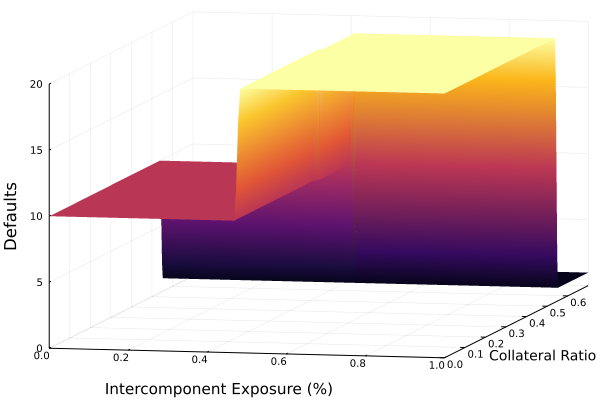

In [65]:
# Plot level of defaults with varying level of deltas and collateral ratios
Plots.surface(vec(delta_values),vec(collateral_range),vec(def_list),camera=(20,30),size=(600,400,700),legend=false,zguidefontsize=13,xguidefontsize=12,zlim=(0,20),xlabel="Intercomponent Exposure (%)",ylabel="Collateral Ratio",zlabel="Defaults")
#savefig("numerical_simulations/delta_defaults_extended.png")

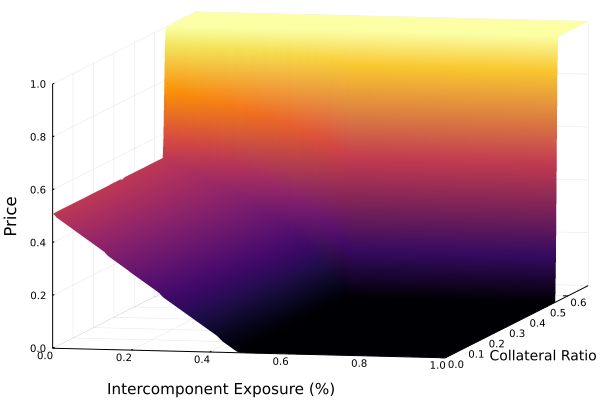

In [66]:
# Plot equilibrium price with varying level of deltas and collateral ratios
Plots.surface(vec(delta_values),vec(collateral_range),vec(price_list),legend=false,camera=(20,30),size=(600,400,700),zlim=(0,1),zguidefontsize=13,xguidefontsize=12,xlabel="Intercomponent Exposure (%)",ylabel="Collateral Ratio",zlabel="Price")
#savefig("numerical_simulations/delta_price_extended.png")

## Variation of the $\delta$-connected network: 2 components of ring networks

In [67]:
delta_star = find_delta_star(n,Dweight,s,e0,epsilon_star,xi,zeta,omega,h0,0)
println("delta^* = ",delta_star[1]) # we multiply by 100 because there are 100 pairs of relationships between the two components

delta^* = 0.0037


In [70]:
ring_delta_values,ring_def_list,ring_price_list,ring_collateral_range=graph_agg_delta(n,Dweight,s,e0,ei,epsilon_star,xi,zeta,omega,h0,k,0);

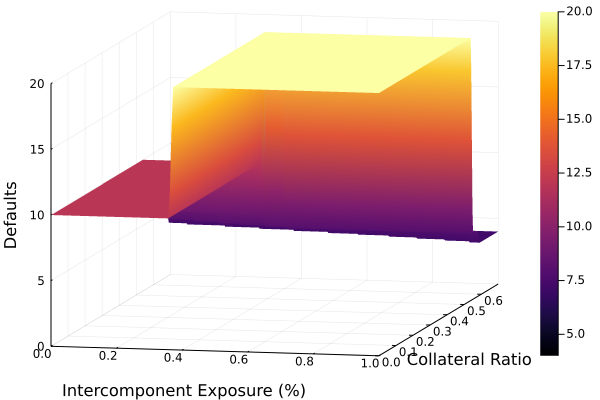

In [71]:
Plots.surface(vec(ring_delta_values),vec(ring_collateral_range),vec(ring_def_list),camera=(20,30),zlim=(0,20),xlabel="Intercomponent Exposure (%)",ylabel="Collateral Ratio",zlabel="Defaults")

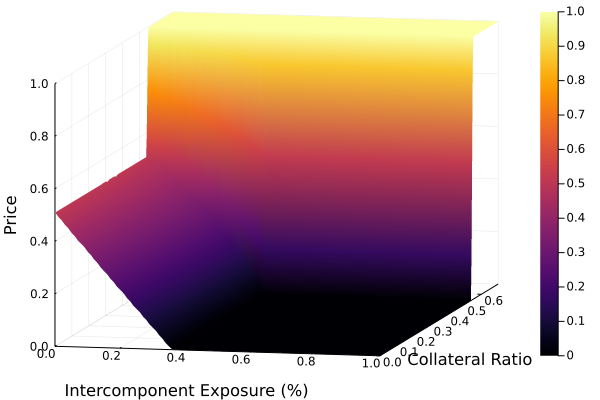

In [72]:
Plots.surface(vec(ring_delta_values),vec(ring_collateral_range),vec(ring_price_list),camera=(20,30),zlim=(0,1),xlabel="Intercomponent Exposure (%)",ylabel="Collateral Ratio",zlabel="Price")

## $\delta^*$ and $\gamma$-convex networks plot
We replicate the experiment evaluating $\delta^*$, labelled as the threshold intercomponent exposure, across various $\delta$-connected networks where the two components are a $\gamma$-convex combination of complete and ring networks. We keep the collateral ratio fixed to $c < c_*$ and the liquidity shock fixed to $\epsilon > \epsilon^*$.

In [73]:
delta_star = []
gamma_convex = 0:0.1:1

for gamma in 0:0.1:1
    # construct gamma-convex network
    delta, default = find_delta_star(n,Dweight,s,e0,epsilon_star,xi,zeta,omega,h0,gamma)
    push!(delta_star,round(delta*100,digits=2)) #convert delta to percentage
end

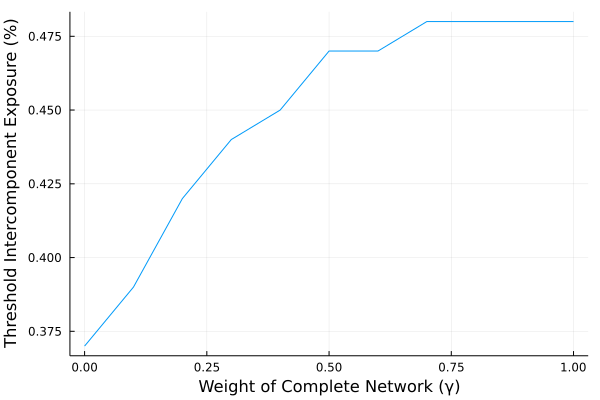

In [74]:
Plots.plot(gamma_convex,delta_star,legend=false,ylabel="Threshold Intercomponent Exposure (%)",xlabel="Weight of Complete Network (γ)")
#savefig("numerical_simulations/delta_star_gamma.png")